In [5]:
import requests

#### Для белка P04637 (p53) получите список его функций (features)

In [23]:
base_url = "https://www.ebi.ac.uk/proteins/api/features"
params = {'accession': 'P04637'} 

response = requests.get(base_url, params=params)

if response.status_code == 200:
    data = response.json()  
    print(f"Protein: {data[0]['entryName']}")
    print(f"Accession: {data[0]['accession']}")
    features = data[0]['features']
    for feature in features[:5]:
        print(f"\nType: {feature['type']}")
        print(f"Description: {feature.get('description', 'N/A')}")
        
else:
    print(f"Ошибка! Код: {response.status_code}")

Protein: P53_HUMAN
Accession: P04637

Type: CHAIN
Description: Cellular tumor antigen p53

Type: DNA_BIND
Description: 

Type: REGION
Description: Interaction with CCAR2

Type: REGION
Description: Interaction with HRMT1L2

Type: REGION
Description: Transcription activation (acidic)


Если что, просто сократила вывод для первых пяти вариантов (`for feature in features[:5]:`)

#### Получите последовательности белков P05067 (APP) и P10636 (Tau). Сравните их длины. Какой белок длиннее и на сколько аминокислот?

In [87]:
base_url = "https://www.ebi.ac.uk/proteins/api/features"
params = {'accession': 'P05067'} 

response = requests.get(base_url, params=params)

if response.status_code == 200:
    data = response.json()  
    print(f"Protein: {data[0]['entryName']}")
    print(f"Accession: {data[0]['accession']}")
    print(f"Seq length: {len(data[0]['sequence'])}")

Protein: A4_HUMAN
Accession: P05067
Seq length: 770


In [40]:
base_url = "https://www.ebi.ac.uk/proteins/api/features"
params = {'accession': 'P10636'} 

response = requests.get(base_url, params=params)

if response.status_code == 200:
    data = response.json()  
    print(f"Protein: {data[0]['entryName']}")
    print(f"Accession: {data[0]['accession']}")
    print(f"Seq length: {len(data[0]['sequence'])}")

Protein: TAU_HUMAN
Accession: P10636
Seq length: 758


In [91]:
770 - 758

12

Или просто объединить в один запрос через список

In [89]:
def compare_protein_lengths():
    proteins = ["P05067", "P10636"]
    lengths = {}
    
    for accession in proteins:
        url = f"https://www.ebi.ac.uk/proteins/api/proteins/{accession}"
        response = requests.get(url, headers={"Accept": "application/json"})
        
        if response.status_code == 200:
            data = response.json()
            length = data['sequence']['length']
            lengths[accession] = length
            print(f"{accession}: {length} аминокислот")
        else:
            print(f"Ошибка для {accession}: {response.status_code}")
    
    if len(lengths) == 2:
        diff = abs(lengths["P05067"] - lengths["P10636"])
        longer = "P05067 (APP)" if lengths["P05067"] > lengths["P10636"] else "P10636 (Tau)"
        print(f"\nБолее длинный белок: {longer}")
        print(f"Разница: {diff} аминокислот")

compare_protein_lengths()

P05067: 770 аминокислот
P10636: 758 аминокислот

Более длинный белок: P05067 (APP)
Разница: 12 аминокислот


#### Получите данные о 5 различных белках (на ваш выбор) через API, используя их accession IDs. Сохраните их entryName и длину последовательности в таблицу

In [64]:
import pandas as pd

def get_protein_info_uniprot(accession_ids):
    proteins_data = []
    
    for accession in accession_ids:
        try:
            url = f"https://rest.uniprot.org/uniprotkb/{accession}"
            headers = {'Accept': 'application/json'}
            
            response = requests.get(url, headers=headers)
            #print(f"Запрос для {accession}: статус {response.status_code}")
            
            if response.status_code == 200:
                data = response.json()
                
                entry_name = data.get('uniProtkbId', 'N/A')
                
                sequence_length = data.get('sequence', {}).get('length', 0)
                
                protein_name = "N/A"
                protein_desc = data.get('proteinDescription', {})
                if 'recommendedName' in protein_desc:
                    protein_name = protein_desc['recommendedName'].get('fullName', {}).get('value', 'N/A')
                
                protein_info = {
                    'Accession_ID': accession,
                    'Entry_Name': entry_name,
                    'Protein_Name': protein_name,
                    'Sequence_Length': sequence_length
                }
                
                proteins_data.append(protein_info)
                
                #print(f" {accession}: {entry_name}, Length={sequence_length}")
                
            else:
                print(f" Ошибка для {accession}: {response.status_code}")
                
        except Exception as e:
            print(f'Ошибка запроса для {accession}: {e}')
                 
    return proteins_data

protein_accessions = [
    'P01889',  # HLA-B
    'P10321',  # HLA-C
    'P01911',  # HLA-DRB1
    'P04439',  # HLA-A
    'P01920',  # HLA-DQB1
]

data = get_protein_info_uniprot(protein_accessions)

df = pd.DataFrame(data)
df

,Accession_ID,Entry_Name,Protein_Name,Sequence_Length
0,P01889,HLAB_HUMAN,"HLA class I histocompatibility antigen, B alph...",362
1,P10321,HLAC_HUMAN,"HLA class I histocompatibility antigen, C alph...",366
2,P01911,DRB1_HUMAN,"HLA class II histocompatibility antigen, DRB1 ...",266
3,P04439,HLAA_HUMAN,"HLA class I histocompatibility antigen, A alph...",365
4,P01920,DQB1_HUMAN,"HLA class II histocompatibility antigen, DQ be...",261


#### Используя API PubMed, найдите 10 самых последних (сортировка по дате) статей по запросу "COVID-19 variants". Выведите их ID и заголовки.

In [96]:
def search_pubmed_articles():
    base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"
    params = {
        'db': 'pubmed',
        'term': 'COVID-19 variants',
        'retmode': 'json',
        'retmax': 10,
        'sort': 'date'
    }
    
    response = requests.get(base_url, params=params)
    
    if response.status_code == 200:
        data = response.json()
        article_ids = data['esearchresult']['idlist']
        
        for article_id in article_ids:
            fetch_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi"
            fetch_params = {
                'db': 'pubmed',
                'id': article_id,
                'retmode': 'json'
            }
            
            fetch_response = requests.get(fetch_url, params=fetch_params)
            if fetch_response.status_code == 200:
                article_data = fetch_response.json()
                title = article_data['result'][article_id]['title']
                print(f"ID: {article_id}")
                print(f"Заголовок: {title}\n")
    
    return article_ids

article_ids = search_pubmed_articles()

ID: 41196059
Заголовок: Mouse-adapted SARS-CoV-2 Omicron BA.5 infection induces post-acute lung fibrosis in BALB/c mice.

ID: 41194062
Заголовок: Dutch participatory surveillance framework for evaluating evolutionary changes on SARS-CoV-2 affecting rapid diagnostic test sensitivity in 2022 - 2023.

ID: 41193798
Заголовок: Assessing phylogenetic confidence at pandemic scales.

ID: 41193785
Заголовок: Organoids in respiratory virus research: advances and perspectives.

ID: 41191496
Заголовок: Fuel-Free Rolosense: Viral Sensing Using Diffusional Particle Tracking.

ID: 41191293
Заголовок: "Just be honest with us": A qualitative analysis of Canadians' public trust during the COVID-19 pandemic.

ID: 41190654
Заголовок: Tradeoffs in viral fitness driven by alternative entry pathways.

ID: 41188882
Заголовок: Development of broadly neutralizing antibodies against Omicron variants from existing neutralizing antibodies in clinical trials.

ID: 41188857
Заголовок: Differential immune profiles in

 #### Напишите функцию get_protein_name(accession), которая принимает на вход accession ID белка и возвращает его название (entryName). Обработайте случай, если белок не найден.

In [98]:
def get_protein_name(accession):
    url = f"https://www.ebi.ac.uk/proteins/api/proteins/{accession}"
    response = requests.get(url, headers={"Accept": "application/json"})
    
    if response.status_code == 200:
        data = response.json()
        return data.get('protein', {}).get('recommendedName', {}).get('fullName', {}).get('value', 'Название не найдено')
    elif response.status_code == 404:
        return "Белок не найден"
    else:
        return f"Ошибка: {response.status_code}"

print(get_protein_name("P04637"))
print(get_protein_name("ALCBC"))

Cellular tumor antigen p53
Ошибка: 400


#### Прочитайте из файла accessions.txt (нужно создать) список из 3-5 accession IDs. Для каждого ID получите из Proteins API и запишите в новый файл его название и организм-источник.

In [108]:
! echo -e "P04637\nP01308\nP00533\nP15056\nQ07812" > accessions.txt

In [113]:
def process_accessions_from_file(file):

    with open(file, 'r') as f:
        accessions = [line.strip() for line in f if line.strip()]
    
    results = []
    
    for accession in accessions:
        url = f"https://www.ebi.ac.uk/proteins/api/proteins/{accession}"
        response = requests.get(url, headers={"Accept": "application/json"})
        
        if response.status_code == 200:
            data = response.json()
            organism = data.get('organism', {}).get('names', [{}])[0].get('value', 'N/A')
            name = data.get('protein', {}).get('recommendedName', {}).get('fullName', {}).get('value', 'N/A')
            
            results.append({
                'accession': accession,
                'name': name,
                'organism': organism
            })
    
    with open('protein_info.txt', 'w') as f:
        f.write("Accession\tName\tOrganism\n")
        for result in results:
            f.write(f"{result['accession']}\t{result['name']}\t{result['organism']}\n")
    
    print("Информация записана в protein_info.txt")

process_accessions_from_file('accessions.txt')

Информация записана в protein_info.txt


In [114]:
! cat protein_info.txt

Accession	Name	Organism
P04637	Cellular tumor antigen p53	Homo sapiens
P01308	Insulin	Homo sapiens
P00533	Epidermal growth factor receptor	Homo sapiens
P15056	Serine/threonine-protein kinase B-raf	Homo sapiens
Q07812	Apoptosis regulator BAX	Homo sapiens


Для найденных в задании 4 статей получите более подробную информацию, используя Eutils API и ID статей (конечная точка efetch.fcgi). Извлеките имена авторов для каждой статьи.

In [116]:
def get_article_authors(article_ids):
    base_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/efetch.fcgi"
    
    for article_id in article_ids:
        params = {
            'db': 'pubmed',
            'id': article_id,
            'retmode': 'xml'
        }
        
        response = requests.get(base_url, params=params)
        
        if response.status_code == 200:
            # Парсим XML для извлечения авторов
            # Это упрощенный пример - в реальности нужно использовать XML парсер
            content = response.text
            print(f"Статья ID: {article_id}")
            # Здесь должен быть код для парсинга XML и извлечения авторов
            print("(Для получения авторов нужен XML парсер)\n")

get_article_authors(article_ids)  # Берем первые 3 статьи

Статья ID: 41196059
(Для получения авторов нужен XML парсер)

Статья ID: 41194062
(Для получения авторов нужен XML парсер)

Статья ID: 41193798
(Для получения авторов нужен XML парсер)

Статья ID: 41193785
(Для получения авторов нужен XML парсер)

Статья ID: 41191496
(Для получения авторов нужен XML парсер)

Статья ID: 41191293
(Для получения авторов нужен XML парсер)

Статья ID: 41190654
(Для получения авторов нужен XML парсер)

Статья ID: 41188882
(Для получения авторов нужен XML парсер)

Статья ID: 41188857
(Для получения авторов нужен XML парсер)

Статья ID: 41188743
(Для получения авторов нужен XML парсер)



#### Напишите команду curl, которая получает данные о белке, выполняет поиск по слову "phosphorylation" (либо другое на ваш выбор) в ответе и выводит строки, содержащие это слово.

In [128]:
! curl -s "https://www.ebi.ac.uk/proteins/api/proteins/P04637" | grep -i "phosphorylation" | wc -l

1


Посчитала количество, чтобы убрать большой вывод результата. Можно убрать `wc -l` и будет все окей

#### Белок Q8WZ42 (Titin):  получить последовательность и разбить на строки по 80 символов


In [135]:
def get_titin_sequence():
    accession = "Q8WZ42"
    url = f"https://www.ebi.ac.uk/proteins/api/proteins/{accession}"
    response = requests.get(url, headers={"Accept": "application/json"})
    
    if response.status_code == 200:
        data = response.json()
        sequence = data['sequence']['sequence']
        
        print(f"Последовательность белка {accession} (Titin):")
        print(f"Общая длина: {len(sequence)} аминокислот")

        # Разбиваем последовательность на строки по 80 символов
        for i in range(0, len(sequence), 80):
            print(sequence[i:i+80])
        
        return sequence 
    else:
        print(f"Ошибка: {response.status_code}")
        return None

titin_sequence = get_titin_sequence()

Последовательность белка Q8WZ42 (Titin):
Общая длина: 34350 аминокислот
MTTQAPTFTQPLQSVVVLEGSTATFEAHISGFPVPEVSWFRDGQVISTSTLPGVQISFSDGRAKLTIPAVTKANSGRYSL
KATNGSGQATSTAELLVKAETAPPNFVQRLQSMTVRQGSQVRLQVRVTGIPTPVVKFYRDGAEIQSSLDFQISQEGDLYS
LLIAEAYPEDSGTYSVNATNSVGRATSTAELLVQGEEEVPAKKTKTIVSTAQISESRQTRIEKKIEAHFDARSIATVEMV
IDGAAGQQLPHKTPPRIPPKPKSRSPTPPSIAAKAQLARQQSPSPIRHSPSPVRHVRAPTPSPVRSVSPAARISTSPIRS
VRSPLLMRKTQASTVATGPEVPPPWKQEGYVASSSEAEMRETTLTTSTQIRTEERWEGRYGVQEQVTISGAAGAAASVSA
SASYAAEAVATGAKEVKQDADKSAAVATVVAAVDMARVREPVISAVEQTAQRTTTTAVHIQPAQEQVRKEAEKTAVTKVV
VAADKAKEQELKSRTKEVITTKQEQMHVTHEQIRKETEKTFVPKVVISAAKAKEQETRISEEITKKQKQVTQEAIRQETE
ITAASMVVVATAKSTKLETVPGAQEETTTQQDQMHLSYEKIMKETRKTVVPKVIVATPKVKEQDLVSRGREGITTKREQV
QITQEKMRKEAEKTALSTIAVATAKAKEQETILRTRETMATRQEQIQVTHGKVDVGKKAEAVATVVAAVDQARVREPREP
GHLEESYAQQTTLEYGYKERISAAKVAEPPQRPASEPHVVPKAVKPRVIQAPSETHIKTTDQKGMHISSQIKKTTDLTTE
RLVHVDKRPRTASPHFTVSKISVPKTEHGYEASIAGSAIATLQKELSATSSAQKITKSVKAPTVKPSETRVRAEPTPLPQ
FPFADTPDTYKSEAGVEVKKEVGVSITGTTVREERFE

#### Сделайте запрос к Proteins API, чтобы получить данные о белке в формате FASTA. Сохраните результат в файл с расширением .fasta

Вывод из R, взяла тот же белок, что выше, чтобы сравнить

`>sp|Q8WZ42|TITIN_HUMAN Titin OS=Homo sapiens OX=9606 GN=TTN PE=1 SV=4
MTTQAPTFTQPLQSVVVLEGSTATFEAHISGFPVPEVSWFRDGQVISTSTLPGVQISFSD
GRAKLTIPAVTKANSGRYSLKATNGSGQATSTAELLVKAETAPPNFVQRLQSMTVRQGSQ
VRLQVRVTGIPTPVVKFYRDGAEIQSSLDFQISQEGDLYSLLIAEAYPEDSGTYSVNATN
SVGRATSTAELLVQGEEEVPAKKTKTIVSTAQISESRQTRIEKKIEAHFDARSIATVEMV
IDGAAGQQLPHKTPPRIPPKPKSRSPTPPSIAAKAQLARQQSPSPIRHSPSPVRHVRAPT
PSPVRSVSPAARISTSPIRSVRSPLLMRKTQASTVATGPEVPPPWKQEGYVASSSEAEMR
ETTLTTSTQIRTEERWEGRYGVQEQVTISGAAGAAASVSASASYAAEAVATGAKEVKQDA
DKSAAVATVVAAVDMARVREPVISAVEQTAQRTTTTAVHIQPAQEQVRKEAEKTAVTKVV
VAADKAKEQELKSRTKEVITTKQEQMHVTHEQIRKETEKTFVPKVVISAAKAKEQETRIS
EEITKKQKQVTQEAIRQETEITAASMVVVATAKSTKLETVPGAQEETTTQQDQMHLSYEK
IMKETRKTVVPKVIVATPKVKEQDLVSRGREGITTKREQVQITQEKMRKEAEKTALSTIA
VATAKAKEQETILRTRETMATRQEQIQVTHGKVDVGKKAEAVATVVAAVDQARVREPREP
GHLEESYAQQTTLEYGYKERISAAKVAEPPQRPASEPHVVPKAVKPRVIQAPSETHIKTT
DQKGMHISSQIKKTTDLTTERLVHVDKRPRTASPHFTVSKISVPKTEHGYEASIAGSAIA
TLQKELSATSSAQKITKSVKAPTVKPSETRVRAEPTPLPQFPFADTPDTYKSEAGVEVKK
EVGVSITGTTVREERFEVLHGREAKVTETARVPAPVEIPVTPPTLVSGLKNVTVIEGESV`

#### Получите информацию о 10 белках разной длины. Постройте в R столбчатую диаграмму (barplot), отображающую длину каждого белка.


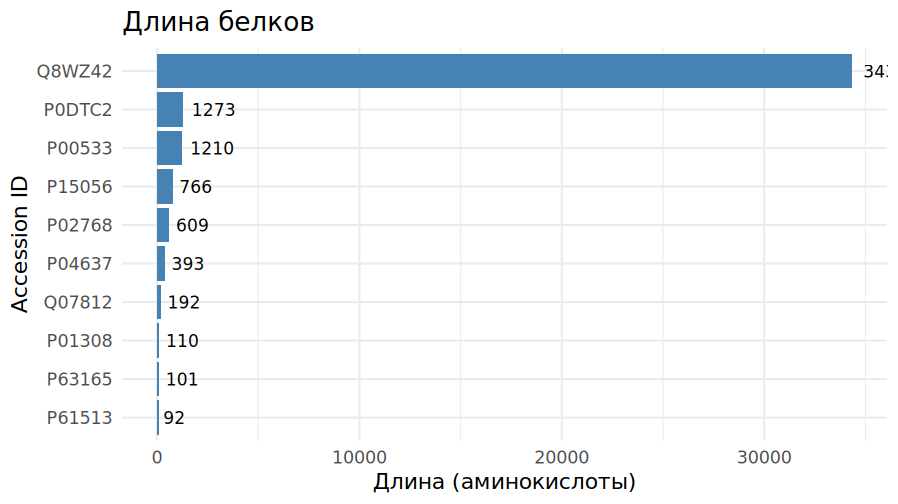!

Вывод работы из R

#### (Python/R): Напишите скрипт, который для заданного гена (например, APOE) находит белки у человека, получает их ID, названия и ссылки на соответствующие записи в UniProt. Сохраните результат в CSV-файл.

In [138]:
import csv

def search_proteins_by_gene(gene_name="APOE", organism="human"):
    url = "https://www.ebi.ac.uk/proteins/api/proteins"
    params = {
        'gene': gene_name,
        'organism': 'Homo sapiens'
    }
    
    response = requests.get(url, params=params, headers={"Accept": "application/json"})
    
    if response.status_code == 200:
        data = response.json()
        
        results = []
        for protein in data:
            accession = protein.get('accession', 'N/A')
            entry_name = protein.get('id', 'N/A')
            protein_name = protein.get('protein', {}).get('recommendedName', {}).get('fullName', {}).get('value', 'N/A')
            uniprot_url = f"https://www.uniprot.org/uniprot/{accession}"
            
            results.append({
                'accession': accession,
                'entry_name': entry_name,
                'protein_name': protein_name,
                'uniprot_url': uniprot_url
            })
        
        with open(f'{gene_name}_proteins.csv', 'w', newline='', encoding='utf-8') as csvfile:
            fieldnames = ['accession', 'entry_name', 'protein_name', 'uniprot_url']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
            
            writer.writeheader()
            for result in results:
                writer.writerow(result)
        
        print(f"Найдено {len(results)} белков для гена {gene_name}")
        print(f"Результаты сохранены в {gene_name}_proteins.csv")
        
        return results
    else:
        print(f"Ошибка: {response.status_code}")
        return []

apoe_proteins = search_proteins_by_gene("APOE")

Найдено 16 белков для гена APOE
Результаты сохранены в APOE_proteins.csv


In [139]:
df = pd.read_csv('APOE_proteins.csv', sep = ',')
df

,accession,entry_name,protein_name,uniprot_url
0,A0A0S2Z3B1,A0A0S2Z3B1_HUMAN,NaN,https://www.uniprot.org/uniprot/A0A0S2Z3B1
1,A0A0S2Z3D5,A0A0S2Z3D5_HUMAN,Apolipoprotein E,https://www.uniprot.org/uniprot/A0A0S2Z3D5
2,A0A0S2Z3J5,A0A0S2Z3J5_HUMAN,NaN,https://www.uniprot.org/uniprot/A0A0S2Z3J5
3,A0A0S2Z3V0,A0A0S2Z3V0_HUMAN,NaN,https://www.uniprot.org/uniprot/A0A0S2Z3V0
4,A0A346DBY2,A0A346DBY2_HUMAN,Apolipoprotein E,https://www.uniprot.org/uniprot/A0A346DBY2
5,D9ZB55,D9ZB55_HUMAN,Apolipoprotein E,https://www.uniprot.org/uniprot/D9ZB55
6,E7ERP7,E7ERP7_HUMAN,Apolipoprotein E,https://www.uniprot.org/uniprot/E7ERP7
7,E9PEV4,E9PEV4_HUMAN,Apolipoprotein E,https://www.uniprot.org/uniprot/E9PEV4
8,H0Y7L5,H0Y7L5_HUMAN,Apolipoprotein E,https://www.uniprot.org/uniprot/H0Y7L5
9,J9ZVQ3,J9ZVQ3_HUMAN,Apolipoprotein E,https://www.uniprot.org/uniprot/J9ZVQ3


#### Ваш коллега написал код, который в цикле делает 100 запросов к API (по 1 белку). Перепишите код, чтобы сделать всего 1 запрос, получающий данные сразу по 100 белкам (используйте соответствующий параметр в Proteins API)

In [155]:
def get_multiple_proteins_optimized(accessions):

    accessions_param = ",".join(accessions)
    
    url = "https://www.ebi.ac.uk/proteins/api/proteins"
    params = {
        'accession': accessions_param,
        'offset': 0,
        'size': len(accessions)
    }
    
    response = requests.get(url, params=params, headers={"Accept": "application/json"})
    
    if response.status_code == 200:
        data = response.json()
        print(f"Успешно получены данные для {len(data)} белков")
        
        for protein in data:
            accession = protein.get('accession', 'N/A')
            name = protein.get('protein', {}).get('recommendedName', {}).get('fullName', {}).get('value', 'N/A')
            length = protein.get('sequence', {}).get('length', 'N/A')
            print(f"{accession}: {name} ({length} а.о.)")
        
        return data
    else:
        print(f"Ошибка: {response.status_code}")
        return []

random = [f"O{str(i).zfill(5)}" for i in range(100, 200)]
results = get_multiple_proteins_optimized(random[:20])

Успешно получены данные для 10 белков
O00100: Phytase A (466 а.о.)
O00101: Nitrate reductase (891 а.о.)
O00102: Ubiquitin-conjugating enzyme E2-18 kDa (166 а.о.)
O00103: Ubiquitin-conjugating enzyme E2-20 kDa (176 а.о.)
O00104: endo-polygalacturonase (365 а.о.)
O00105: Isopullulanase (564 а.о.)
O00107: Phytase A (487 а.о.)
O00110: Putative transcription factor ovo-like protein 3 (190 а.о.)
O00115: Deoxyribonuclease-2-alpha (360 а.о.)
O00116: Alkyldihydroxyacetonephosphate synthase, peroxisomal (658 а.о.)


In [ ]:
%%R
get_protein_fasta_r <- function(accession) {
  url <- paste0("https://www.ebi.ac.uk/proteins/api/proteins/", accession)
  
  # Запрашиваем данные в формате FASTA
  response <- GET(url, accept("application/x-fasta"))
  
  if (status_code(response) == 200) {
    fasta_content <- content(response, "text")
    
    # Сохраняем в файл
    filename <- paste0(accession, ".fasta")
    writeLines(fasta_content, filename)
    
    cat("FASTA файл сохранен как:", filename, "\n")
    cat("Содержимое:\n")
    cat(fasta_content)
    
    return(fasta_content)
  } else {
    cat("Ошибка:", status_code(response), "\n")
    return(NULL)
  }
}

# Пример использования
fasta_data <- get_protein_fasta_r("P04637")

#### Создайте сценарий, который целенаправленно вызывает ошибку 404 при работе с API, и корректно их обрабатывает с выводом информативных сообщений.

In [166]:
def test_error_handling():

    test_accessions = [
        "P04637",      #  p53
        "ID",  # невалидный
        "P01308",      #  insulin
        "e1234",   # невалидный
        "P00533",      #  EGFR
        "12345"        # невалидный
    ]
        
    for accession in test_accessions:
        url = f"https://www.ebi.ac.uk/proteins/api/proteins/{accession}"
        
        try:
            response = requests.get(url, headers={"Accept": "application/json"})
            
            if response.status_code == 200:
                data = response.json()
                name = data.get('protein', {}).get('recommendedName', {}).get('fullName', {}).get('value', 'N/A')
                print(f"{accession} - {name}")
                
            elif response.status_code == 404:
                print(f" 404: Белок с accession '{accession}' не найден")
                
            elif response.status_code == 400:
                print(f" 400: Неверный запрос для '{accession}'")
                
            elif response.status_code == 500:
                print(f" 500: Внутренняя ошибка сервера для '{accession}'")
                
        except requests.exceptions.RequestException as e:
            print(f" Не удалось подключиться к API для '{accession}'")
            print(f"  Детали: {e}")
            
        except json.JSONDecodeError as e:
            print(f" Ошибка парсинга JSON: для '{accession}'")
            print(f"  Детали: {e}")


test_error_handling()

P04637 - Cellular tumor antigen p53
 400: Неверный запрос для 'ID'
P01308 - Insulin
 400: Неверный запрос для 'e1234'
P00533 - Epidermal growth factor receptor
 400: Неверный запрос для '12345'


#### Напишите скрипт, который принимает название гена, ищет по нему белки у человека, а затем для первого найденного белка ищет статьи в PubMed, упоминающие его ген. Выведите ID статей.

In [176]:
import requests

def gene_to_publications(gene_name):

    uniprot_url = "https://rest.uniprot.org/uniprotkb/search"
    params = {
        'query': f'gene:{gene_name} AND organism_id:9606',
        'format': 'json',
        'size': 1,
        'fields': 'accession,protein_name,gene_names'
    }
    
    response = requests.get(uniprot_url, params=params)
    
    if response.status_code == 200:
        try:
            data = response.json()
            results = data.get('results', [])
            
            if not results:
                print(f"Белки для гена {gene_name} не найдены")
                return []
            
            first_protein = results[0]
            protein_accession = first_protein.get('primaryAccession')
            protein_name = first_protein.get('proteinDescription', {}).get('recommendedName', {}).get('fullName', {}).get('value', 'N/A')
            
            print(f"Найден белок: {protein_accession} - {protein_name}")
            
        except:
            print("Ошибка парсинга ответа от UniProt")
            return []
    else:
        print(f"Ошибка при поиске белков: {response.status_code}")
        return []
    
    pubmed_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"
    pubmed_params = {
        'db': 'pubmed',
        'term': f'"{gene_name}"[Gene] AND human[Organism]',
        'retmode': 'json',
        'retmax': 10,
        'sort': 'relevance'
    }
    
    pubmed_response = requests.get(pubmed_url, params=pubmed_params)
    
    if pubmed_response.status_code == 200:
        try:
            pubmed_data = pubmed_response.json()
            article_ids = pubmed_data.get('esearchresult', {}).get('idlist', [])
            
            print(f"Найдено статей: {len(article_ids)}")
            print("ID статей:")
            for article_id in article_ids:
               print(f" - {article_id}")
    
            return 
        except:
            print("Ошибка парсинга ответа от PubMed")
            return []
    else:
        print(f"Ошибка при поиске в PubMed: {pubmed_response.status_code}")
        return []


gene_to_publications("APOE")

Найден белок: A0A0S2Z3D5 - Apolipoprotein E
Найдено статей: 10
ID статей:
 - 38266107
 - 33340485
 - 37605285
 - 34058468
 - 34958025
 - 39278789
 - 28647612
 - 36377985
 - 34151296
 - 30884759


#### Напишите bash-скрипт, который с помощью curl и jq (если установлен) извлекает accession ID из заранее сохраненного JSON-файла с данными белка и выводит его.

In [177]:
! curl -s "https://www.ebi.ac.uk/proteins/api/proteins/P04637" -H "Accept: application/json" > protein_data.json

In [179]:
# ! cat protein_data.json

In [184]:
! grep -oP '"accession":"\K[^"]*' protein_data.json
! grep -o '"accession":"[^"]*"' protein_data.json | head -1 | awk -F'"' '{print $4}'

P04637
P04637


#### Выберите любой интересующий вас белок или ген. Самостоятельно придумайте и выполните 3 различных запроса к Proteins API или PubMed, которые дадут о нем новую информацию. Опишите, что вы узнали

In [195]:
def investigate_tp53():
    
    accession = 'P10321'  # HLA-C

    url = f"https://www.ebi.ac.uk/proteins/api/proteins/{accession}"
    response = requests.get(url)
    
    if response.status_code == 200:
        data = response.json()
        
        name = data.get('protein', {}).get('recommendedName', {}).get('fullName', {}).get('value', 'N/A')
        gene = data.get('gene', [{}])[0].get('name', {}).get('value', 'N/A')
        organism = data.get('organism', {}).get('names', [{}])[0].get('value', 'N/A')
        length = data.get('sequence', {}).get('length', 'N/A')
        
        print(f"   • Название: {name}")
        print(f"   • Ген: {gene}")
        print(f"   • Организм: {organism}")
        print(f"   • Длина: {length} аминокислот")
        print(f"   • Accession: {data.get('accession', 'N/A')}")
  
        if 'comments' in data:
            for comment in data['comments']:
                if comment.get('type') == 'FUNCTION':
                    print(f"   • Функция: {comment.get('text', [{}])[0].get('value', 'N/A')}")
                    break
        
        if 'comments' in data:
            for comment in data['comments']:
                if comment.get('type') == 'SUBCELLULAR LOCATION':
                    print(f"   • Субклеточная локализация: {comment.get('text', [{}])[0].get('value', 'N/A')}")
                    break
        
        if 'comments' in data:
            for comment in data['comments']:
                if comment.get('type') == 'BIOPROCESS':
                    print(f"   • Биологический процесс: {comment.get('text', [{}])[0].get('value', 'N/A')}")
                    break
        
        if 'features' in data:
            unique_features = set()
            for feature in data['features']:
                if feature.get('type'):
                    unique_features.add(feature['type'])

            print(f"   • Типы особенностей: {', '.join(sorted(unique_features))}")
            
            important_features = ['DNA binding', 'metal ion binding', 'domain', 'motif']
            for feature_type in important_features:
                for feature in data['features']:
                    if feature.get('type') == feature_type and feature.get('description'):
                        print(f"   • {feature_type}: {feature['description']}")
                        break
        
        clinical_count = 0
        clinical_info = []
        
        for feature in data.get('features', []):
            if feature.get('type') == 'mutagenesis site' and feature.get('description'):
                clinical_count += 1
                if clinical_count <= 3:  # Показываем только первые 3
                    clinical_info.append(feature['description'])
        
        print(f"   • Клинически значимые сайты: {clinical_count}")
        if clinical_info:
            print(f"   • Примеры клинических особенностей:")
            for clinical in clinical_info:
                print(f"     - {clinical}")
                
        if 'comments' in data:
            for comment in data['comments']:
                if comment.get('type') == 'DISEASE':
                    print(f"   • Связь с заболеваниями: {comment.get('text', [{}])[0].get('value', 'N/A')}")
                    break
                    
        ptm_count = 0
        for feature in data.get('features', []):
            if feature.get('type') in ['modified residue', 'glycosylation site', 'phosphorylation site']:
                ptm_count += 1
        print(f"   • Посттрансляционные модификации: {ptm_count}")
        
    else:
        print(f"Ошибка: не удалось получить данные для {accession}, статус код: {response.status_code}")

investigate_tp53()

   • Название: HLA class I histocompatibility antigen, C alpha chain
   • Ген: HLA-C
   • Организм: Homo sapiens
   • Длина: 366 аминокислот
   • Accession: P10321
   • Функция: Antigen-presenting major histocompatibility complex class I (MHCI) molecule with an important role in reproduction and antiviral immunity (PubMed:11172028, PubMed:20104487, PubMed:20439706, PubMed:20972337, PubMed:24091323, PubMed:28649982, PubMed:29312307). In complex with B2M/beta 2 microglobulin displays a restricted repertoire of self and viral peptides and acts as a dominant ligand for inhibitory and activating killer immunoglobulin receptors (KIRs) expressed on NK cells (PubMed:16141329). In an allogeneic setting, such as during pregnancy, mediates interaction of extravillous trophoblasts with KIR on uterine NK cells and regulate trophoblast invasion necessary for placentation and overall fetal growth (PubMed:20972337, PubMed:24091323). During viral infection, may present viral peptides with low affinity 

Кратко: HLA-C играет роль в представлении антигенов для иммунного ответа, участвует в репродуктивных процессах через взаимодействие с NK-клетками и ассоциирована с аутоиммунными заболеваниями через презентацию аутоантигена ADAMTSL5.

#### Последние 10 статей

In [189]:

    pubmed_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esearch.fcgi"
    pubmed_params = {
        'db': 'pubmed',
        'term': 'HLA-C[Gene Name]',
        'retmode': 'json',
        'retmax': 5,
        'sort': 'pub date'
    }
    
    pubmed_response = requests.get(pubmed_url, params=pubmed_params)
    
    if pubmed_response.status_code == 200:
        pubmed_data = pubmed_response.json()
        article_ids = pubmed_data.get('esearchresult', {}).get('idlist', [])

        if article_ids:
            fetch_url = "https://eutils.ncbi.nlm.nih.gov/entrez/eutils/esummary.fcgi"
            fetch_params = {
                'db': 'pubmed',
                'id': ','.join(article_ids),
                'retmode': 'json'
            }
            
            fetch_response = requests.get(fetch_url, params=fetch_params)
            if fetch_response.status_code == 200:
                articles_data = fetch_response.json()
                print(f"   • Последние статьи:")
                for article_id in article_ids:
                    title = articles_data['result'][article_id].get('title', 'Нет заголовка')
                    pub_date = articles_data['result'][article_id].get('pubdate', 'Нет даты')
                    print(f"     - {article_id} ({pub_date}): {title}")

   • Последние статьи:
     - 39731480 (2025 Dec): Existence and significance of anti-HLA-C autoantibodies to primary and persistent platelet transfusion refractoriness in patients with hematologic disorders: a retrospective study from a single centre.
     - 41194668 (2025 Nov 6): Mapping CMV-related immune signatures in blood, aorta and perivascular mediastinal adipose tissue.
     - 41162199 (2025 Nov): The Novel HLA-C*12:05:03 Allele Identified in a Turkish Patient.
     - 41128369 (2025 Nov): Association of Primary Sclerosing Cholangitis With HLA-C*07:02 in a Japanese Population.
     - 40668377 (2025 Nov): Anti-CD19 chimeric antigen receptor T-cell therapy in a highly sensitized patient with focal and segmental glomerulosclerosis.
